This arm is the space L(2,5)
This arm is the space L(911,1233)
This arm is the space L(-6765736,18902633)
This arm is the space L(4744,2889)
(3,0,0.56456)
(1,0,0.5)
(1,0,0.78)
(0,0,0.56)
(2,0,0.2)


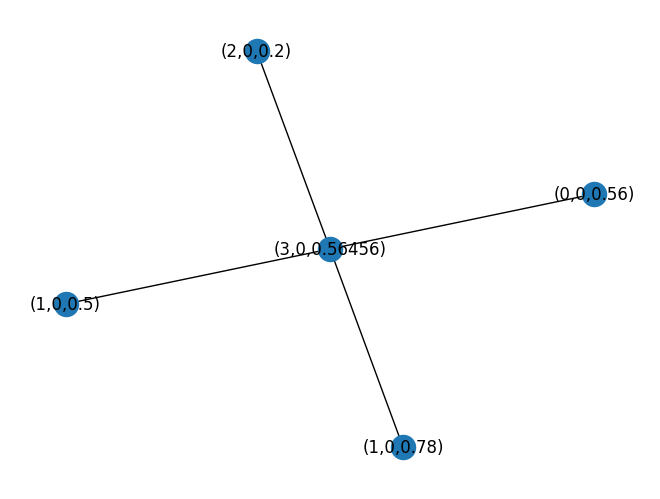

In [43]:
import networkx as nx
import numpy as np
from fractions import Fraction
from decimal import Decimal

class PlumbingNode:
    def __init__(self,euler_number,g,a):
        self.euler_number = euler_number
        self.genus = g
        self.area = a
    
    def __str__(self):
        return "({0},{1},{2})".format(self.euler_number, self.genus, self.area)

class PlumbingGraph(nx.Graph):
    def __init__(self):
        super(PlumbingGraph,self).__init__()
        
    def add_node(self, node_for_adding, **attr):
        nx.Graph(self).add_node(node_for_adding, **attr)
        
    def total_area(self):
        total = 0
        for n in nodes:
            total += n.area
            
    def total_genus(self):
        total_genus = 0
        for n in nodes:
            total_genus += n.genus
    
    def attach_chain_to(self,node,chain):
        self.add_edge(node, chain.head)
        
    def attach_chain_between(self, node1, node2, chain):
        self.add_edge(node1, chain.head)
        self.add_edge(node2, chain.tail)
            
class Chain(PlumbingGraph):
    def __init__(self, coefficients, area):
        if len(area) != len(coefficients):
            raise Exception("Area vector does not match the size of the arm.")
            
        
        super(Chain,self).__init__()
        
        previous_node = None
        for i,c in enumerate(coefficients):
            current_node = PlumbingNode(c, 0, area[i])
            self.add_node(current_node)
            
            if i == 0:
                self.head = current_node
            elif i == len(coefficients) - 1:
                self.tail = current_node
            else:
                self.add_edge(previous_node, current_node)
                
            previous_node = current_node
            

def compute_continued_fraction(coefficients):
    if len(coefficients) == 1:
        return Fraction(coefficients[0],1)
    
    return Fraction(coefficients[0],1) - 1/compute_continued_fraction(coefficients[1:])




G = PlumbingGraph()

root_node = PlumbingNode(3,0,.56456)
G.add_node(root_node)

arms = [
    [1,2,3],
    [1,4,6,7,8],
    [0,3,5,7,4,4,6,78,8,4],
    [2,3,5,7,8,4]
]

areas = [
    [0.5,0.5,0.5],
    [.78,.45,.345,.45,.89],
    [.56, .78, .543, .67, .46, .54, .45, .67, .565, .45],
    [.2, .2, .45, .5, .5, .45]
]

for i,arm in enumerate(arms):
    r = compute_continued_fraction(arm)
    print("This arm is the space L({0},{1})".format(r.numerator,r.denominator))
    c = Chain(arm, areas[i])
    G.attach_chain_to(root_node, c)


for i in G:
    print(i)
                 
# Plot the result
edge_nodes = set(G) - {center_node}
pos = nx.spring_layout(G.subgraph(edge_nodes))
pos[center_node] = np.array([0, 0])  
nx.draw(G, pos, with_labels=True)




